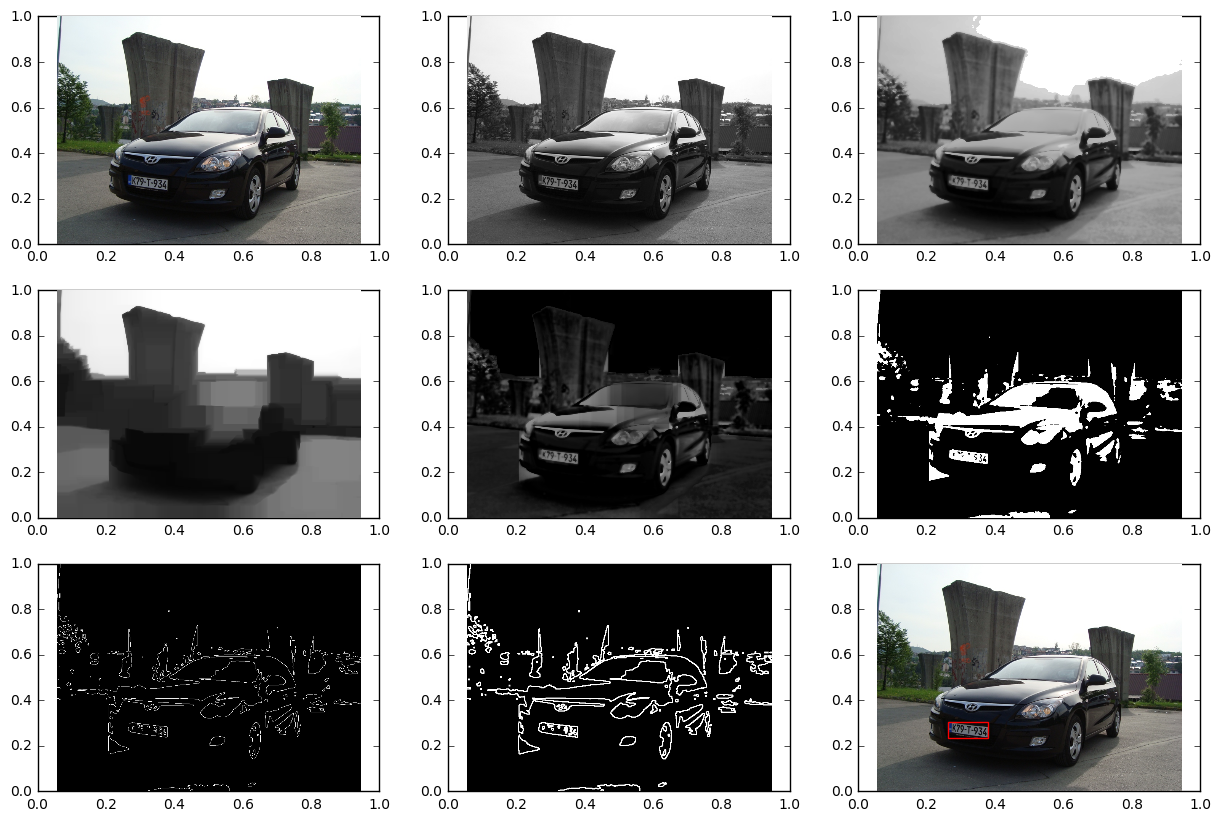

In [45]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Učitaj sliku
slika = cv2.imread("auto_1.jpg")

# Pretvori sliku u crno bijelu
slika_siva = cv2.cvtColor(slika, cv2.COLOR_RGB2GRAY)

'''
Primjeni zamućenje sive slike ali s naglaskom na očuvanje rubova
koristiti Bilateralni Filter 


Parametri: 
    9 - veličina filtera, 
    75 - odstupanje od susjednih piksela u pogledu vrijednosti u prostoru boja, 
    75 - odstupanje od susjednih piksela u udaljenosti.
'''
slika_bez_suma = cv2.bilateralFilter(slika_siva,9,75,75)


# Ujednačavanje vrijednosti histograma
slika_histogram = cv2.equalizeHist(slika_bez_suma)

# Primjena operacije otvaranja koko bismo odstranili bjeline sa slike
jezgra = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
slika_otvaranje = cv2.morphologyEx(slika_bez_suma,cv2.MORPH_OPEN,jezgra,iterations=15)

# Primjena operacije oduzimanja, kako bismo oduzeli sve regije koje su se istakle operacijom otvaranja
# s ovim korakom se odrstanjuju regije pozadine
slika_oduzeta = cv2.subtract(slika_histogram,slika_otvaranje)


# Primjena odsjecanja vrijednosti kako bismo dobili crno bijelu sliku
_, slika_crno_bijela = cv2.threshold(slika_oduzeta,0,255,cv2.THRESH_OTSU)

# Primjena Canny detektora rubova
slika_canny = cv2.Canny(slika_crno_bijela,250,255)

# Operacija diletacije kako bismo proširili rubove
jezgra = np.ones((3,3), np.uint8)
slika_diletacija = cv2.dilate(slika_canny,jezgra,iterations=1)

# Pronalazak svih kontura te sortiranje i uzimanje prvih 10 kontura jer su najvjerojatnije one registracijske oznake
konture, hijerarhija = cv2.findContours(slika_diletacija, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
konture = sorted(konture, key = cv2.contourArea, reverse = True)[:10]


# Pronalazak konture koja bi mogla biti registracijska oznaka
registracijska_oznaka = None

for kontura in konture:
    # Aproksimiraj složene konture s krivuljom te vjerojatnosti pogreške od 6% s ovim ukljanjaju se nazubljeni rubovi
    # te se eliminiraju mogućnosti pronalaska regija koji imaju lažne oštre rubove
    duljina_luka = cv2.arcLength(kontura, True)
    aproksimacija = cv2.approxPolyDP(kontura, 0.06 * duljina_luka, True)
    # Ako naša aproksimirana kontura ima 4 oštra ruba rada smo pronašli registraciju
    if len(aproksimacija) == 4:
        registracijska_oznaka = cv2.boundingRect(kontura)
        break
        
figura, osa = plt.subplots(3,3, figsize=(15, 10))
ax = figura.add_subplot(3,3,1)
ax.axis('off')
plt.imshow(cv2.cvtColor(slika, cv2.COLOR_BGR2RGB))
ax = figura.add_subplot(3,3,2)
ax.axis('off')
plt.imshow(cv2.cvtColor(slika_siva, cv2.COLOR_BGR2RGB))
ax = figura.add_subplot(3,3,3)
ax.axis('off')
plt.imshow(cv2.cvtColor(slika_histogram, cv2.COLOR_BGR2RGB))
ax = figura.add_subplot(3,3,4)
ax.axis('off')
plt.imshow(cv2.cvtColor(slika_otvaranje, cv2.COLOR_BGR2RGB))

ax = figura.add_subplot(3,3,5)
ax.axis('off')
plt.imshow(cv2.cvtColor(slika_oduzeta, cv2.COLOR_BGR2RGB))
ax = figura.add_subplot(3,3,6)
ax.axis('off')
plt.imshow(cv2.cvtColor(slika_crno_bijela, cv2.COLOR_BGR2RGB))
ax = figura.add_subplot(3,3,7)
ax.axis('off')
plt.imshow(cv2.cvtColor(slika_canny, cv2.COLOR_BGR2RGB))
ax = figura.add_subplot(3,3,8)
ax.axis('off')
plt.imshow(cv2.cvtColor(slika_diletacija, cv2.COLOR_BGR2RGB))
ax = figura.add_subplot(3,3,9)
ax.axis('off')
plt.imshow(cv2.cvtColor(slika, cv2.COLOR_BGR2RGB))
x1, y1, w, h = registracijska_oznaka
rect = patches.Rectangle((x1,y1), w, h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

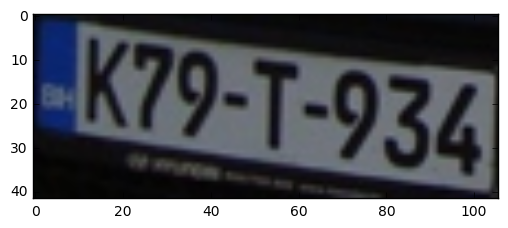

In [50]:
x, y, w, h = registracijska_oznaka
registracija = slika[y:y+h, x:x+w]
plt.imshow(cv2.cvtColor(registracija, cv2.COLOR_RGB2BGR))